# Experimentation Script
This script is used for evaluation on the dataset, and evaluate on the effect of different models on an image instance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cv2
from tqdm import tqdm

# Reading in data

In [2]:
dist = pd.read_csv('./resnet101_matches_distance.csv').values
fname = pd.read_csv('./resnet101_matches_filename.csv').values

good = pd.read_csv('./sift_matches_distance.csv').values
fgood = pd.read_csv('./sift_matches_filename.csv').values

train_xy = pd.read_csv('train.csv', index_col=0)
test_path = pd.read_csv('imagenames.csv')['id'].values

with open(f'./kmeans_coords.pckl','rb') as f:
    clustered_coords = pickle.load(f)

with open(f'./kmeans_fnames.pckl','rb') as f:
    clustered_fnames = pickle.load(f)

In [3]:
train_i = {}
test_i = {}

train_xy = pd.read_csv('train.csv')
train_path = train_xy['id'].values
test_path = pd.read_csv('imagenames.csv')['id'].values

for f in train_path:
    i = cv2.imread('./train/' + f + '.jpg')
    train_i[f] = i
for f in test_path:
    i = cv2.imread('./test/' + f + '.jpg')
    test_i[f] = i

# Train Distribution

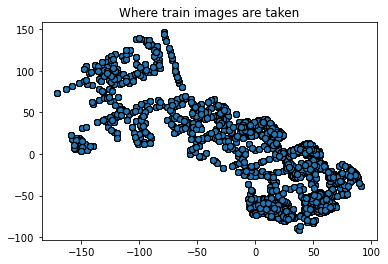

In [4]:
plt.scatter(train_xy['x'],train_xy['y'],edgecolors='black')
plt.title('Where train images are taken')
plt.show()

# Testing on basic models
To toggle the experimental models, the following variables can be changed:
* `i`: The index of the test image on the test dataset, in the order of `imagenames.csv`
* `top`: Number of top best candidates to plot out

In [5]:
# Get the coordinate of a training image
get_coord = lambda name: train_xy.loc[train_xy['id']==name,['x','y']].values

# Get all CNN matches within a top range for a test instance, defined by a threshold
extract_match = lambda i, thresh: fname[i,np.argwhere(dist[i] < dist[i,0] + thresh)]

## Top SIFT Candidates

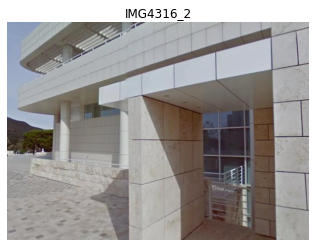

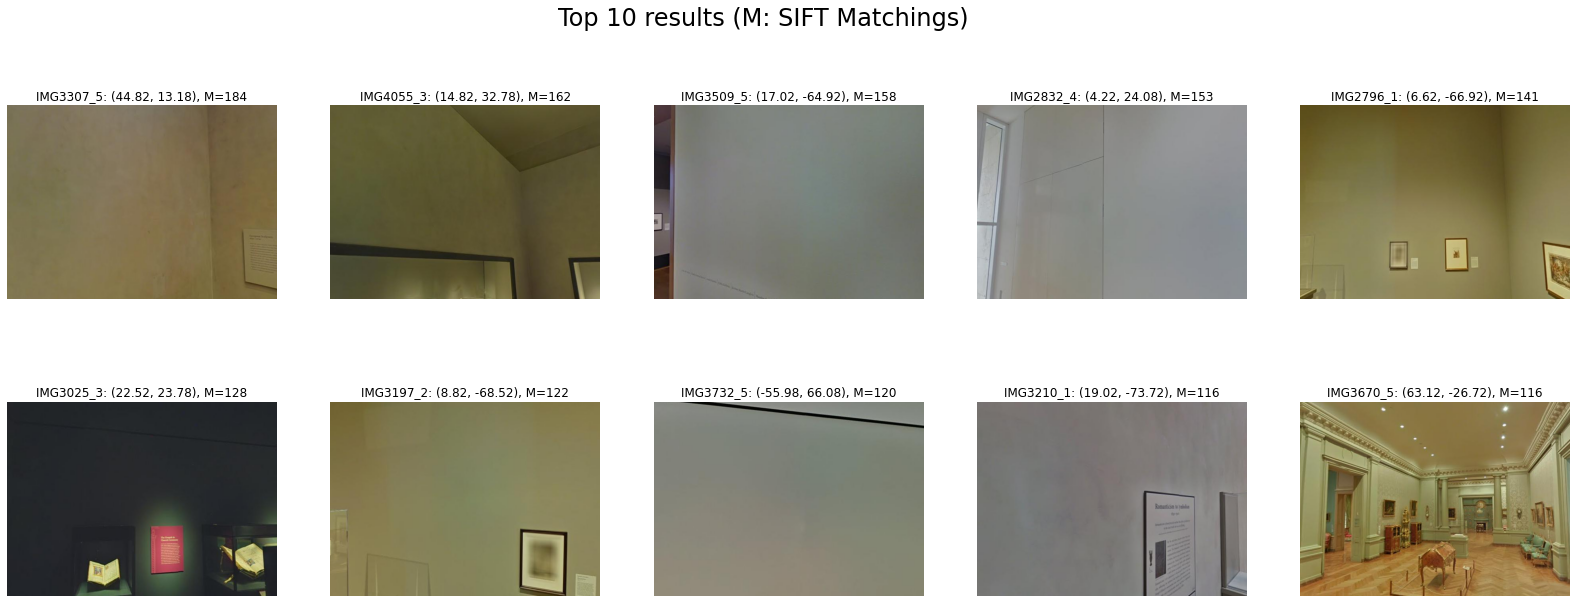

In [138]:
i=29
top = 10
test_img = test_i[test_path[i]]
train_res = fgood[i,:top]

plt.imshow(test_img[:,:,::-1])
plt.title(f'{test_path[i]}')
plt.axis('off')
plt.show()

_,ax = plt.subplots(int(top/5),5,figsize=(28,5*int(top/5)))
plt.suptitle(f'Top {top} results (M: SIFT Matchings)', fontsize=24)
for j,train in enumerate(train_res):
    train_img = train_i[train]
    coor = get_coord(train)
    ax[int(j/5),j%5].imshow(train_img[:,:,::-1])
    ax[int(j/5),j%5].set_title(f'{train}: ({coor[0,0]:.2f}, {coor[0,1]:.2f}), M={good[i,j]:.0f}')
    ax[int(j/5),j%5].axis('off')

# Top CNN Candidates

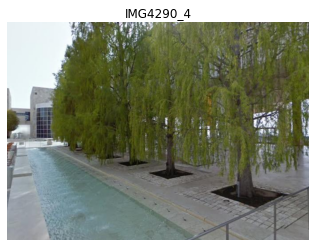

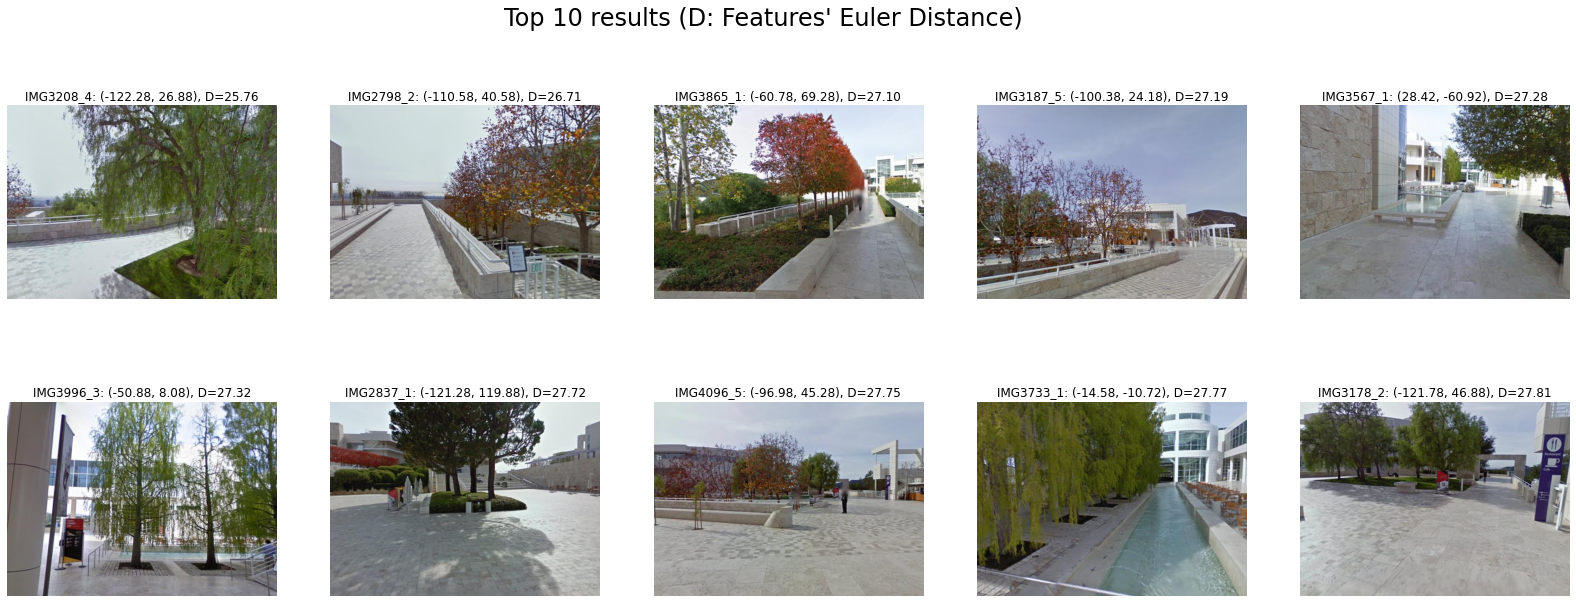

In [141]:
i=3
top = 10

test_img = test_i[test_path[i]]
train_res = fname[i,:top]

plt.imshow(test_img[:,:,::-1])
plt.title(f'{test_path[i]}')
plt.axis('off')
plt.show()

_,ax = plt.subplots(int(top/5),5,figsize=(28,5*int(top/5)))
plt.suptitle(f'Top {top} results (D: Features\' Euler Distance)', fontsize=24)
for j,train in enumerate(train_res):
    train_img = train_i[train]
    coor = get_coord(train)
    ax[int(j/5),j%5].imshow(train_img[:,:,::-1])
    ax[int(j/5),j%5].set_title(f'{train}: ({coor[0,0]:.2f}, {coor[0,1]:.2f}), D={dist[i,j]:.2f}')
    ax[int(j/5),j%5].axis('off')

## Ranked by CNN Similarity, on top of SIFT Candidates
* Change `limit` to set how many top SIFT Candidates to take from

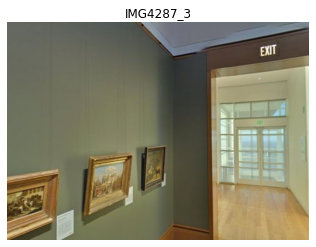

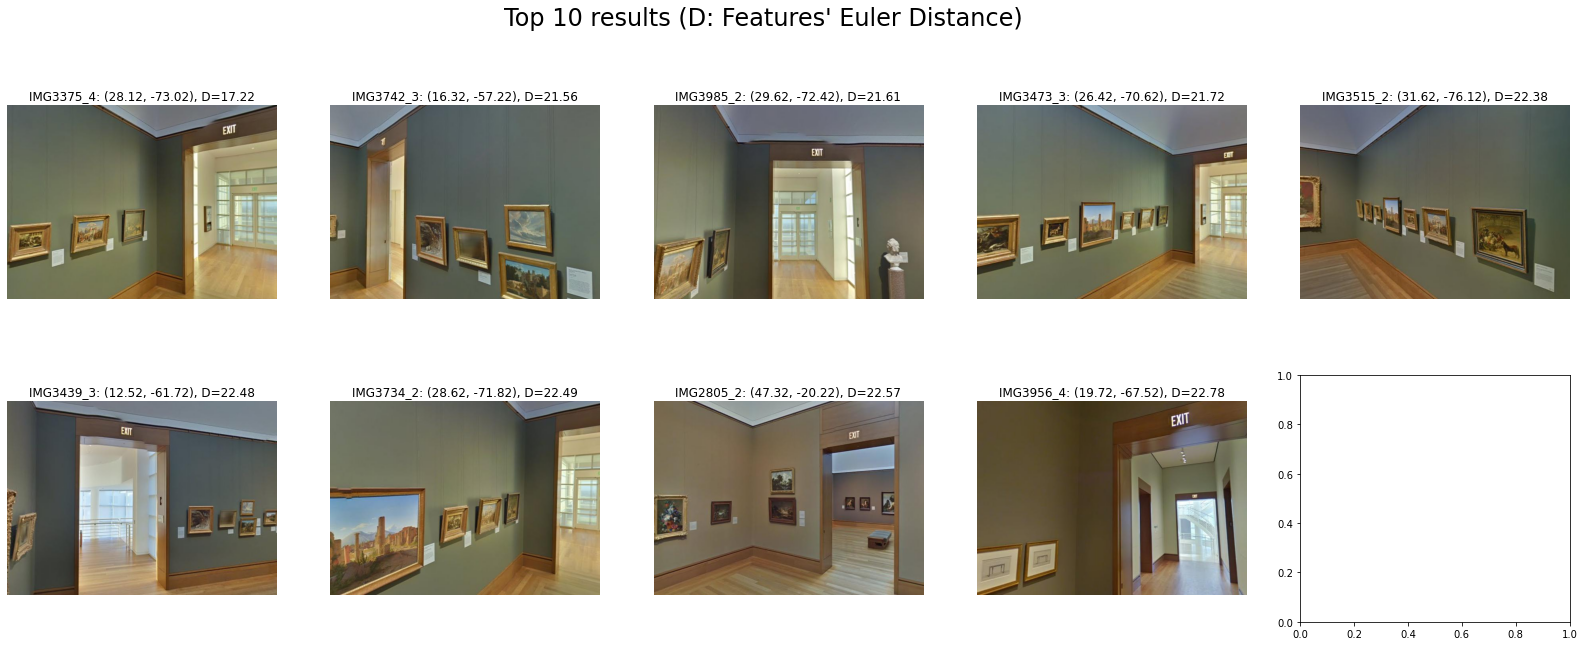

In [143]:
i=0
top = 10
limit = 1500

test_img = test_i[test_path[i]]
train_res = fname[i,:top]

plt.imshow(test_img[:,:,::-1])
plt.title(f'{test_path[i]}')
plt.axis('off')
plt.show()

top_sift = fgood[i,:limit]

_,ax = plt.subplots(int(top/5),5,figsize=(28,5*int(top/5)))
plt.suptitle(f'Top {top} results (D: Features\' Euler Distance)', fontsize=24)
j = 0
for train in train_res:
    if j == top: break
    if train not in top_sift: continue
    train_img = train_i[train]
    coor = get_coord(train)
    ax[int(j/5),j%5].imshow(train_img[:,:,::-1])
    ax[int(j/5),j%5].set_title(f'{train}: ({coor[0,0]:.2f}, {coor[0,1]:.2f}), D={dist[i,j]:.2f}')
    ax[int(j/5),j%5].axis('off')
    j += 1

## Ranked by SIFT, on top CNN candidates
* Change `threshold` to set the top range of CNN candidates to take from

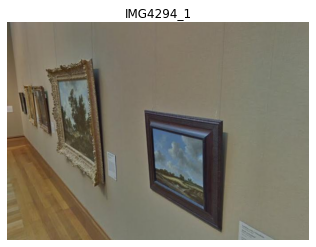

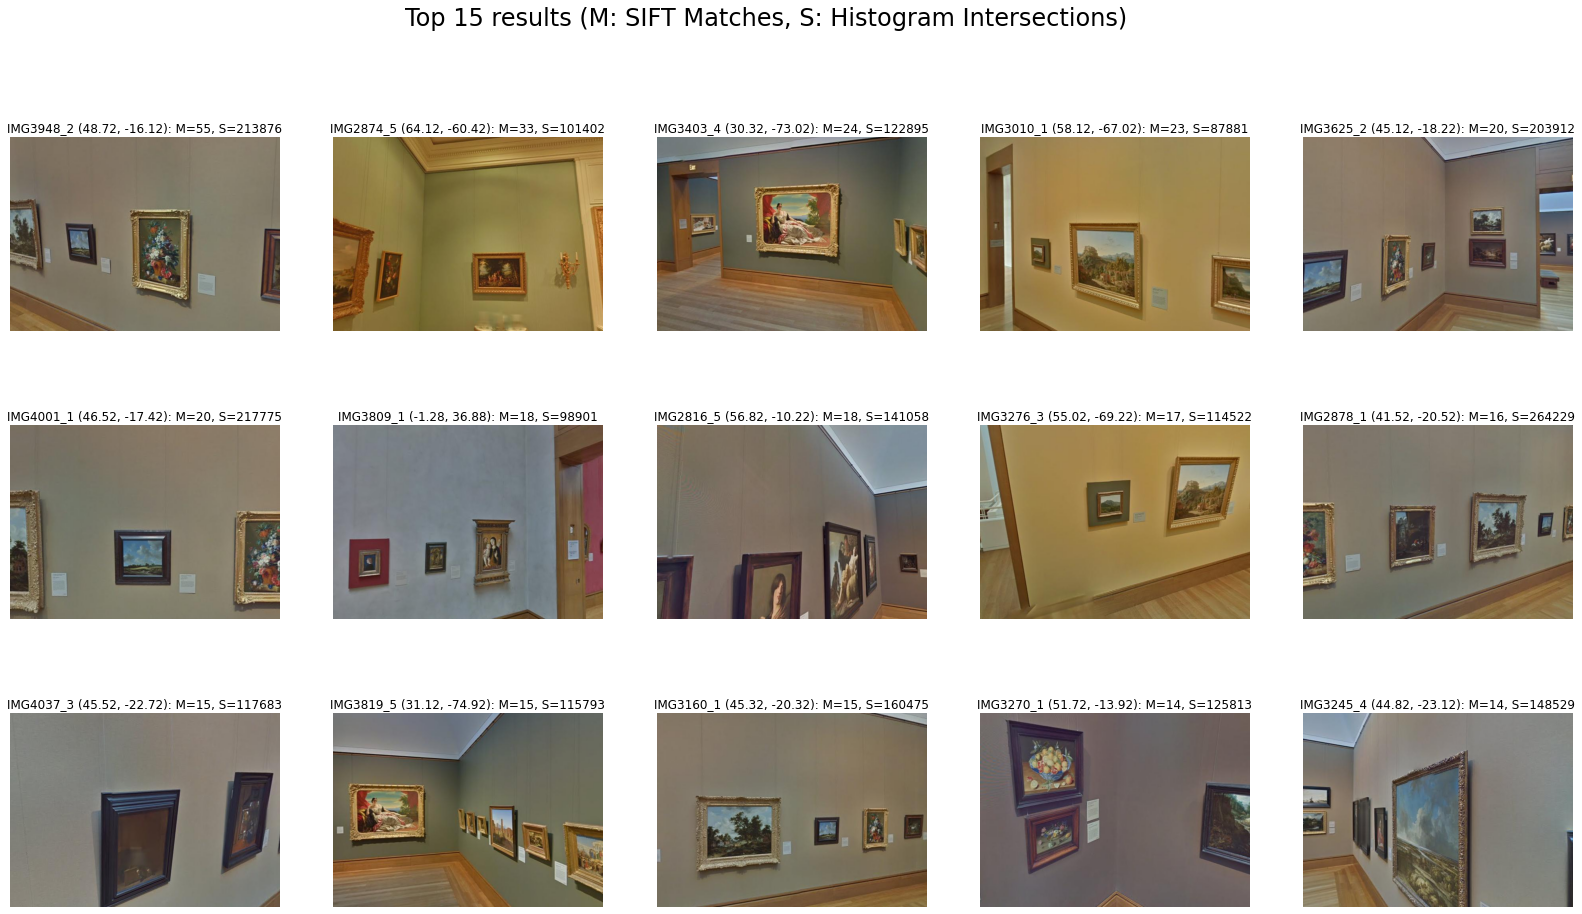

In [142]:
i=7
top = 15
threshold = 5

test_img = test_i[test_path[i]]
train_res = fgood[i,:]

plt.imshow(test_img[:,:,::-1])
plt.title(f'{test_path[i]}')
plt.axis('off')
plt.show()

top_cnn = extract_match(i,threshold).flatten()

hist_test = cv2.calcHist([test_img],[0],None,[256],[0,256])

_,ax = plt.subplots(int(top/5),5,figsize=(28,5*int(top/5)))
plt.suptitle(f'Top {top} results (M: SIFT Matches, S: Histogram Intersections)', fontsize=24)
j = 0
for idx,train in enumerate(train_res):
    if j == top: break
    if train not in top_cnn: continue
    train_img = train_i[train]
    hist_train = cv2.calcHist([train_img],[0],None,[256],[0,256])
    hist_intersection = cv2.compareHist(hist_train,hist_test,cv2.HISTCMP_INTERSECT)
    coor = get_coord(train)
    ax[int(j/5),j%5].imshow(train_img[:,:,::-1])
    ax[int(j/5),j%5].set_title(f'{train} ({coor[0,0]:.2f}, {coor[0,1]:.2f}): M={good[i,idx]:.0f}, S={hist_intersection:.0f}')
    ax[int(j/5),j%5].axis('off')
    j += 1